## Installing Dependencies

In [ ]:
!pip install torch torchvision torchaudio stable-baselines3[extra] protobuf==3.20.* pydirectinput pyautogui opencv-python mss pytesseract

## Creating a Custom Environment

In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Discrete, Box

In [2]:
class Game(Env):
    def __init__(self):
        self.observation_space = Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8)
        self.action_space = Discrete(3)

        self.cap = mss()

        # Game location hard coded only for Brave may not work for other browsers
        self.game_location = {'top': 225, 'left': 575, 'width': 300, 'height': 200}
        self.done_location = {'top': 220, 'left': 835, 'width': 250, 'height': 40}

    def step(self, action):
        '''
        Possible actions:
        0: Jump
        1: Duck
        2: Do nothing
        '''
        action_map = {
            0: "space",
            1: "down",
            2: "no_op"
        }

        if action != 2:
            pydirectinput.press(action_map[action]) # Switched from pyautogui to pydirectinput coz its faster
        
        done, done_cap = self.get_done()
        new_observation = self.get_observation()
        reward = 1

        info = {}

        return new_observation, reward, done, False, info
    
    def render(self):
        cv2.imshow("Game", np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    def close(self):
        cv2.destroyAllWindows()
    
    def reset(self, seed=None):
        '''
        To start new episode
        '''
        super().reset(seed=seed)
        time.sleep(1)
        pydirectinput.click(200, 200) # Get focus back on the game
        pydirectinput.press("space") # Start
        info = {}
        return self.get_observation(), info

    def get_observation(self):
        '''
        Get game play area
        '''
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        channel = np.reshape(resized, (1, 83, 100))
        return channel
    
    def get_done(self):
        '''
        Get game over info
        '''
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]

        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res == "GAME":
            done = True
         
        return done, done_cap

## Testing the Custom Environment

In [3]:
from stable_baselines3.common import env_checker

In [3]:
env = Game()

In [5]:
env_checker.check_env(env)

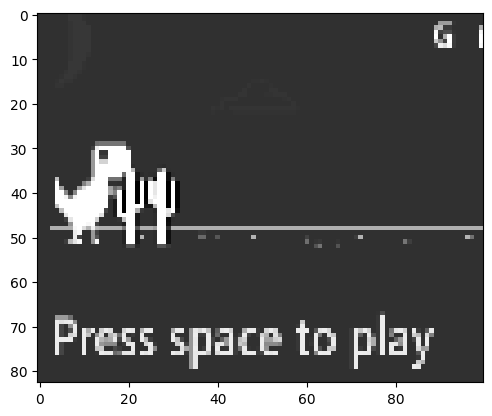

In [38]:
obs = env.get_observation()
plt.imshow(obs[0], cmap="gray")

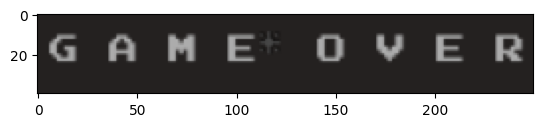

In [39]:
done, done_cap = env.get_done()
plt.imshow(done_cap)

In [42]:
pytesseract.image_to_string(done_cap)

'GAME OVER\n'

In [43]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [44]:
done

True

In [45]:
for episode in range(5):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        obs, reward, done, _, _ = env.step(env.action_space.sample()) # Testing using random actions (out of 0-2)
        total_reward += reward
    
    print(f"Episode: {episode} finished with reward: {total_reward}")

Episode: 0 finished with reward: 16
Episode: 1 finished with reward: 16
Episode: 2 finished with reward: 14
Episode: 3 finished with reward: 16
Episode: 4 finished with reward: 22


## Training the Model

In [4]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import DQN

In [5]:
CHECKPOINT_DIR = r'./train'
LOG_DIR = r'./logs'

In [6]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__()
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f"best_model_{self.n_calls}")
            self.model.save(model_path)
        
        return True

In [7]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [8]:
model = DQN("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR, buffer_size=500000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs\DQN_4
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.8     |
|    ep_rew_mean      | 15.8     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 27       |
|    total_timesteps  | 63       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16       |
|    ep_rew_mean      | 16       |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 55       |
|    total_timesteps  | 128      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.4     |
|    ep_rew_mean      | 16.4     |
|    exploration_rate | 0.981    |
| time/               |        

## Testing the Model

In [9]:
model.load(os.path.join(CHECKPOINT_DIR, "best_model_100000"))

In [ ]:
for episode in range(1):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    
    print(f"Episode {episode} reward: {total_reward}")
    time.sleep(2)
